In [12]:
import numpy as np
import pandas as pd
import torch
from sc_sharp import scSHARP
from test_model import test_model
import utilities
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statistics

In [5]:
grid_results = pd.read_csv("grid_search_pbmc_output/combined.csv", header=None, index_col=0)
grid_results.columns = ["Total Accuracy", "Val Accuracy", "Test Accuracy", "Total SD", "Val SD", "Test SD", "Config", "Dropout", "Batch", "Neighbors"]
grid_results['GCN Layers'] = grid_results['Config'].apply(lambda x: x.split('_')[0])
grid_results['Final Embedding'] = grid_results['Config'].apply(lambda x: x.split('_')[1].split(".")[0])
grid_results['GCN Layers'] = pd.to_numeric(grid_results['GCN Layers'])
grid_results['Final Embedding'] = pd.to_numeric(grid_results['Final Embedding'])
grid_results.sort_values("Val Accuracy", ascending=False).head(10)

,Total Accuracy,Val Accuracy,Test Accuracy,Total SD,Val SD,Test SD,Config,Dropout,Batch,Neighbors,GCN Layers,Final Embedding
0,,,,,,,,,,,,
98,0.959807,0.941689,0.0,0.000524,0.002700,0.0,2_40.txt,0.0,50,5,2,40
16,0.959729,0.941287,0.0,0.001116,0.005750,0.0,2_25.txt,0.0,95,2,2,25
4,0.959625,0.940751,0.0,0.000812,0.004182,0.0,2_25.txt,0.0,35,2,2,25
161,0.959625,0.940751,0.0,0.000793,0.004085,0.0,2_60.txt,0.0,95,5,2,60
154,0.959443,0.939812,0.0,0.001093,0.005633,0.0,2_60.txt,0.0,65,2,2,60
157,0.959157,0.939812,0.0,0.001011,0.002230,0.0,2_60.txt,0.0,80,2,2,60
107,0.959339,0.939276,0.0,0.000736,0.003794,0.0,2_40.txt,0.0,95,5,2,40
139,0.959079,0.939142,0.0,0.000859,0.002543,0.0,2_15.txt,0.0,80,2,2,15
160,0.959287,0.939008,0.0,0.000565,0.002913,0.0,2_60.txt,0.0,95,2,2,60


<AxesSubplot:xlabel='Final Embedding', ylabel='Val Accuracy'>

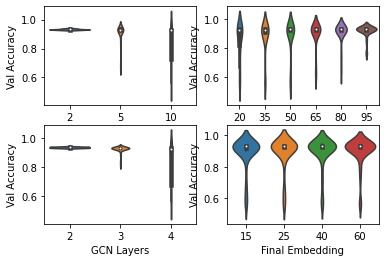

In [5]:
fig, axs = plt.subplots(2,2)
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Val Accuracy"], ax = axs[0][0])
sns.violinplot(x=grid_results["Batch"], y=grid_results["Val Accuracy"], ax = axs[0][1])
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Val Accuracy"], ax = axs[1][0])
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Val Accuracy"], ax = axs[1][1])

<AxesSubplot:xlabel='Batch', ylabel='Val Accuracy'>

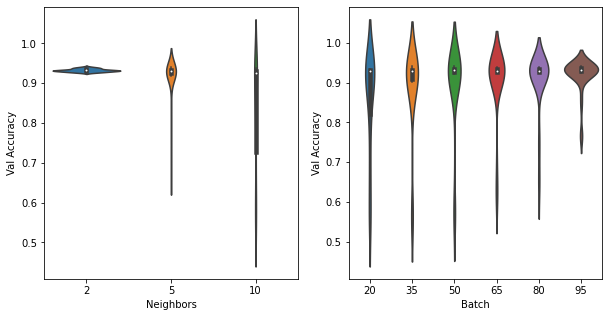

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Val Accuracy"], ax = axs[0])
sns.violinplot(x=grid_results["Batch"], y=grid_results["Val Accuracy"], ax = axs[1])

<AxesSubplot:xlabel='Final Embedding', ylabel='Val Accuracy'>

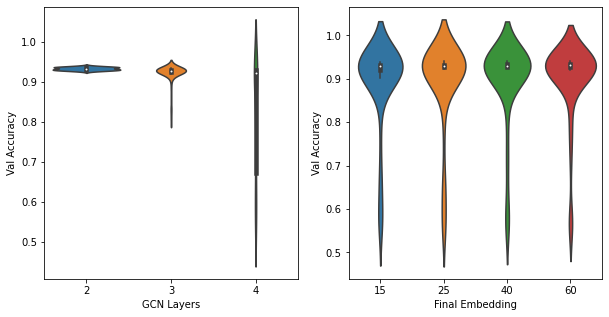

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Val Accuracy"], ax = axs[0])
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Val Accuracy"], ax = axs[1])

accuracy results generated this way:

srun --partition=gpu --mem=130g --time=500 python -u test_model.py
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/pbmc_test/"]
    tools = ["sctype","scsorter","scina", "singler", "scpred"]
    votes_necessary = .51
    model_file = "configs/2_40.txt"
    neighbors = 5
    batch_size=50
    training_epochs=150
    random_inits = 5
    counts="counts.csv"
    meta="labels_cd4-8.csv"
    meta_col = 0
    df = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits, counts=counts, meta=meta, meta_col=meta_col)
    df.to_csv("pbmc_test_results.csv")


In [13]:
results = pd.read_csv("pbmc_test_results.csv", index_col=0)
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_test,GCN,0.930186,0.937344,0.681247,0.000749,0.000207,0.019805
1,pbmc_test,Max Col.,0.921346,0.937523,0.358772,0.000000,0.000000,0.000000
2,pbmc_test,Confident Labels,NaN,0.937523,NaN,0.000000,0.000000,0.000000
3,pbmc_test,sctype,0.971137,0.973760,0.879944,0.000000,0.000000,0.000000
4,pbmc_test,scsorter,0.714819,0.716012,0.673336,0.000000,0.000000,0.000000
5,pbmc_test,scina,0.733328,0.753519,0.031177,0.000000,0.000000,0.000000
6,pbmc_test,singler,0.702813,0.719959,0.106561,0.000000,0.000000,0.000000
7,pbmc_test,scpred,0.744176,0.761535,0.140530,0.000000,0.000000,0.000000
8,pbmc_test,Tool Avg.,0.773255,0.784957,0.366310,0.111774,0.107426,0.383681


(0.0, 1.0)

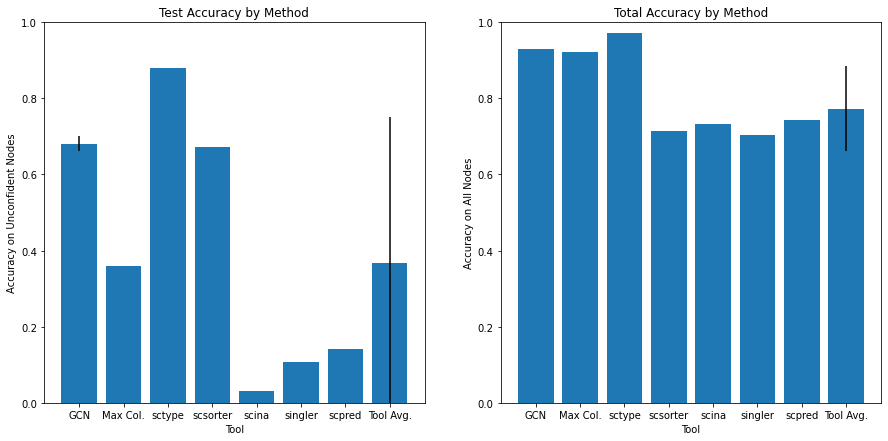

In [14]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots(1,2,figsize=(15, 7))
ax[0].bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax[0].set_xlabel("Tool")
ax[0].set_ylabel("Accuracy on Unconfident Nodes")
ax[0].set_title("Test Accuracy by Method")
ax[1].bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax[1].set_xlabel("Tool")
ax[1].set_ylabel("Accuracy on All Nodes")
ax[1].set_title("Total Accuracy by Method")
ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])

In [3]:
results = pd.read_csv("pbmc_test_results_marker_only.csv", index_col=0)
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_test,GCN,0.963864,0.964680,0.954001,0.000204,0.000139,0.002276
1,pbmc_test,Max Col.,0.958325,0.964778,0.880320,0.000000,0.000000,0.000000
2,pbmc_test,Confident Labels,NaN,0.964778,NaN,0.000000,0.000000,0.000000
3,pbmc_test,sctype,0.971137,0.973749,0.939564,0.000000,0.000000,0.000000
4,pbmc_test,scsorter,0.714819,0.770163,0.045795,0.000000,0.000000,0.000000
5,pbmc_test,scina,0.733328,0.793133,0.010385,0.000000,0.000000,0.000000
6,pbmc_test,Tool Avg.,0.806428,0.845682,0.331915,0.142942,0.111502,0.526538


Text(0.5, 1.0, 'Total Accuracy by Method')

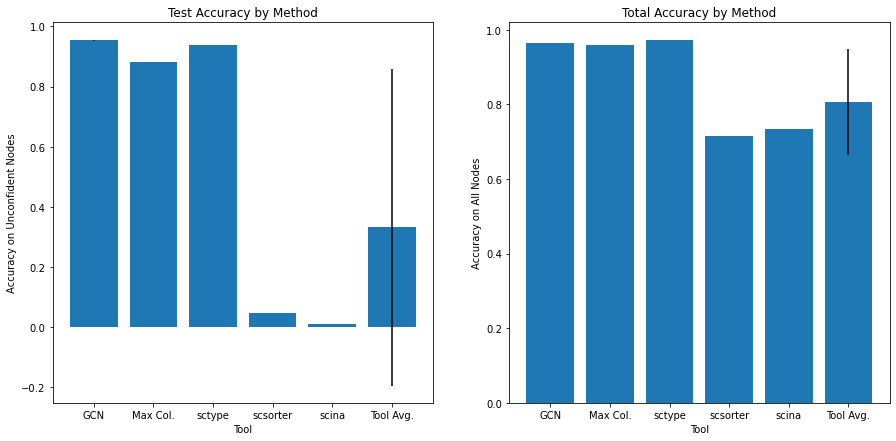

In [4]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots(1,2,figsize=(15, 7))
ax[0].bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax[0].set_xlabel("Tool")
ax[0].set_ylabel("Accuracy on Unconfident Nodes")
ax[0].set_title("Test Accuracy by Method")
ax[1].bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax[1].set_xlabel("Tool")
ax[1].set_ylabel("Accuracy on All Nodes")
ax[1].set_title("Total Accuracy by Method")

In [14]:
data_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/counts.csv"
tool_preds = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/preds.csv"
#tool_list = ["scina", "scsorter", "sctype", "singler", "scpred"]
tool_list = ["scina", "scsorter", "sctype"]
marker_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/markers.txt"
neighbors=5
config="configs/2_40.txt"
sharp = scSHARP(data_path, tool_preds, tool_list, marker_path, neighbors, config, ncells=5000)
sharp.load_model("pbmc_test_trained_model_8_markers_only")
preds, train_nodes, test_nodes, keep_cells = sharp.run_prediction(training_epochs=0, thresh=0.51, batch_size=50, seed=8)

In [15]:
meta_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/labels_cd4-8.csv"
metadata = pd.read_csv(meta_path, index_col=0, nrows=5000)
real_y, names = pd.factorize(metadata.iloc[:,0], sort=True)
print(names)
real_y = real_y[keep_cells]
real_y.shape

Index(['b_cells', 'cd14_monocytes', 'cd4_t_cell', 'cd56_nk', 'cd8_t_cell'], dtype='object')


(5000,)

In [43]:
preds[train_nodes]

tensor([4, 3, 2,  ..., 4, 2, 4], device='cuda:0')

In [32]:
real_y[train_nodes]

array([4, 3, 2, ..., 4, 4, 2])

In [16]:
utilities.validation_metrics(torch.tensor(real_y), preds.cpu(), train_nodes, test_nodes)

(0.9070000052452087,
 array([[ 581,    0,    2,    0,    0],
        [   1,  124,   10,    0,    0],
        [   0,    2, 2234,    2,  249],
        [   0,    0,    9,  484,   15],
        [   0,    0,  169,    6, 1112]]),
 0.9065119028091431,
 array([[ 581,    0,    2,    0,    0],
        [   1,  120,    9,    0,    0],
        [   0,    2, 1967,    2,  229],
        [   0,    0,    9,  457,   14],
        [   0,    0,  161,    6, 1093]]),
 0.9135446548461914,
 array([[  4,   1,   0,   0],
        [  0, 267,   0,  20],
        [  0,   0,  27,   1],
        [  0,   8,   0,  19]]))

In [17]:
int_df = sharp.run_interpretation()
int_df

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


0
10
20
30
40


,b_cells,cd14_monocytes,cd4_t_cell,cd56_nk,cd8_t_cell
AL627309.1,tensor(-0.0032),tensor(0.),tensor(0.),tensor(-0.0010),tensor(0.)
RP11-206L10.2,tensor(0.0006),tensor(0.0006),tensor(0.0001),tensor(0.0048),tensor(-0.0014)
LINC00115,tensor(0.0059),tensor(-0.0159),tensor(1.0987e-05),tensor(-0.0033),tensor(0.0003)
NOC2L,tensor(0.1158),tensor(0.),tensor(-0.0238),tensor(0.0495),tensor(-0.0225)
KLHL17,tensor(0.),tensor(0.),tensor(3.9937e-05),tensor(0.),tensor(0.)
...,...,...,...,...,...
MT-CYB,tensor(5.8610),tensor(0.2519),tensor(1.7905),tensor(14.9632),tensor(-4.5009)
AC145212.1,tensor(-0.0002),tensor(0.),tensor(8.4329e-05),tensor(0.),tensor(0.)
AL592183.1,tensor(0.0003),tensor(0.),tensor(-0.0003),tensor(-0.0016),tensor(0.0018)
PNRC2.1,tensor(-0.0218),tensor(0.),tensor(-0.0010),tensor(-0.0084),tensor(0.0021)


In [18]:
scale_int_df = pd.DataFrame(preprocessing.scale(int_df))
scale_int_df.columns = int_df.columns
scale_int_df.index = int_df.index
statistics.mean(scale_int_df.iloc[:,0])

1.3421340424491925e-19

[Text(0.5, 14.09375, 'Cell Type')]

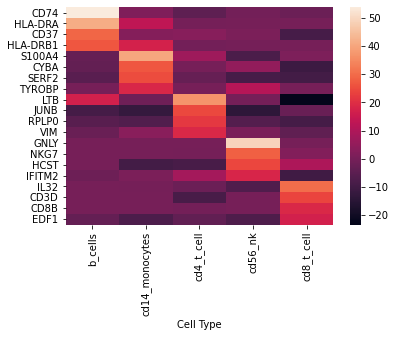

In [19]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

[Text(0.5, 14.09375, 'Cell Type')]

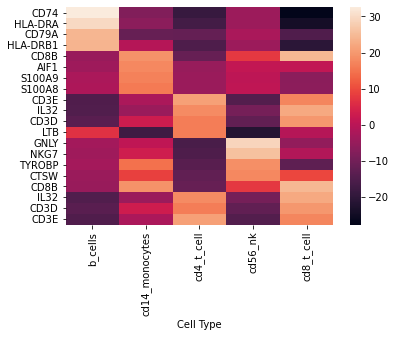

In [40]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [8]:
int_df = pd.read_csv("pbmc_test_interpretation_markers_only_3_test.csv", index_col=0)

scale_int_df = pd.DataFrame(preprocessing.scale(int_df))
scale_int_df.columns = int_df.columns
scale_int_df.index = int_df.index
statistics.mean(scale_int_df.iloc[:,0])



-2.2508155923315823e-18

[Text(0.5, 14.09375, 'Cell Type')]

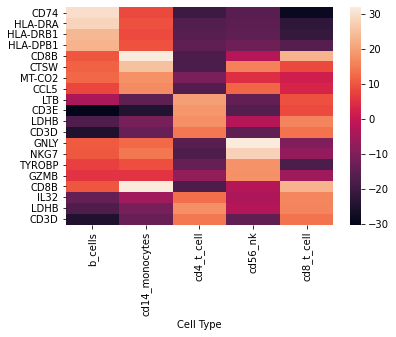

In [9]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [28]:
scale_int_df.sort_values("cd4_t_cell", ascending=False).loc['CD3G',:]

b_cells          -0.035266
cd14_monocytes    0.011065
cd4_t_cell       -0.366170
cd56_nk          -0.112239
cd8_t_cell        1.164784
Name: CD3G, dtype: float64

In [12]:
(int_df['cd8_t_cell'] - int_df["cd4_t_cell"]).sort_values(ascending=False)

CD8B      195.379651
CTSW      136.848256
CCL5      113.952810
HCST       95.061545
CD8A       89.288700
             ...    
CORO1B    -58.203480
CD3E      -62.557420
FTH1      -67.799429
S100A4    -70.289234
LTB       -84.600580
Length: 17980, dtype: float64

In [13]:
int_df.sort_values("cd8_t_cell", ascending=False).loc["CD8A",:]

b_cells           10.709266
cd14_monocytes    92.354900
cd4_t_cell       -93.201584
cd56_nk           21.603033
cd8_t_cell        -3.912884
Name: CD8A, dtype: float64

In [4]:
meta_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/labels_cd4-8.csv"
labels = pd.read_csv(meta_path, index_col=0)
labels

,labels
CTCAATTGCTTGAG-1-15,cd8_t_cell
ATGTTGCTTTGCGA-1-34,cd56_nk
TGATCGGACACAAC-1-41,cd4_t_cell
ACAAAGGAAGATGA-1-74,cd4_t_cell
CAATATGATGCTTT-1-20,cd4_t_cell
...,...
GAACCTGAGTCCTC-1-39,b_cells
ACGGTAACTAACGC-1-57,cd14_monocytes
AAGATGGACACTCC-1-27,cd8_t_cell
CATGCGCTTAACCG-1-26,cd4_t_cell


In [3]:
conf_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_test/confident_labels.csv", index_col=0)
conf_labels

,0
0,4.0
1,3.0
2,2.0
3,2.0
4,2.0
...,...
76876,0.0
76877,1.0
76878,4.0
76879,2.0


In [31]:
umap_embedding = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_test/umap_embedding.csv", index_col=0)
umap_embedding['real labels'] = labels

umap_embedding['confident labels'] = conf_labels.astype('int').to_numpy().flatten()
map_dict = {-1:"unknown", 0:"b_cells", 1:"cd14_monocytes", 2:"cd4_t_cell", 3:"cd56_nk", 4:"cd8_t_cell"}
umap_embedding['confident labels'] = umap_embedding["confident labels"].map(map_dict)

In [29]:
umap_embedding['confident labels']

CTCAATTGCTTGAG-1-15        cd8_t_cell
ATGTTGCTTTGCGA-1-34           cd56_nk
TGATCGGACACAAC-1-41        cd8_t_cell
ACAAAGGAAGATGA-1-74        cd8_t_cell
CAATATGATGCTTT-1-20        cd8_t_cell
                            ...      
GAACCTGAGTCCTC-1-39           b_cells
ACGGTAACTAACGC-1-57    cd14_monocytes
AAGATGGACACTCC-1-27        cd8_t_cell
CATGCGCTTAACCG-1-26        cd8_t_cell
GGAGTTTGTTGACG-1-27        cd8_t_cell
Name: confident labels, Length: 76881, dtype: object

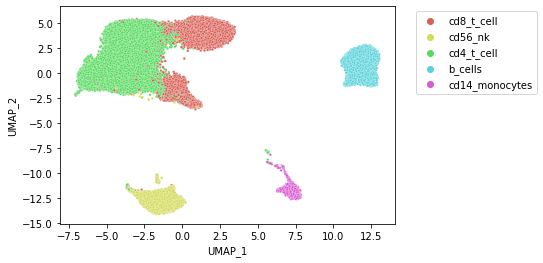

In [8]:
sns.scatterplot(data=umap_embedding, x="UMAP_1", y="UMAP_2", hue="real labels", s=6, palette=dict(cd8_t_cell='#db5f57', cd56_nk="#d3db57", cd4_t_cell = "#57db5f", b_cells='#57d3db', cd14_monocytes='#db57d3'))
plt.legend(bbox_to_anchor=(1.05,1))

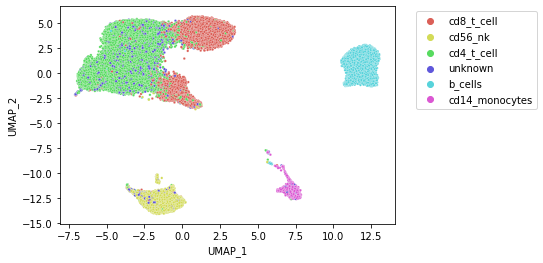

In [32]:
sns.scatterplot(data=umap_embedding, x="UMAP_1", y="UMAP_2", hue="confident labels", s=6, palette=dict(cd8_t_cell='#db5f57', cd56_nk="#d3db57", cd4_t_cell = "#57db5f", b_cells='#57d3db', cd14_monocytes='#db57d3', unknown='#5f57db'))
plt.legend(bbox_to_anchor=(1.05,1))

In [11]:
#conf_labels = conf_labels.astype('int').to_numpy().flatten()
np.count_nonzero(conf_labels[conf_labels==-1])

5874

In [47]:
conf_labels[-20:]

array([ 2,  4,  1,  0,  2,  2,  4,  2,  0,  3, -1,  4,  2,  4, -1,  0,  1,
        4,  2,  4])